## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt

## Data Preprocessing

In [2]:
def data_prep(X,y,sub_sample,average,noise,time=500):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:time]
    # print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    # print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    # print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    # print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y

def test_data_prep(X, y, time):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:time]
    # print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    total_X = X_max
    total_y = y
    # print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X, total_y

In [3]:
def load_data(time=500, debug=False, onehot=False): 

## Loading the dataset
    X_test = np.load("X_test.npy")
    y_test = np.load("y_test.npy")
    person_train_valid = np.load("person_train_valid.npy")
    X_train_valid = np.load("X_train_valid.npy")
    y_train_valid = np.load("y_train_valid.npy")
    person_test = np.load("person_test.npy")

    ## Adjusting the labels so that 

    # Cue onset left - 0
    # Cue onset right - 1
    # Cue onset foot - 2
    # Cue onset tongue - 3

    y_train_valid -= 769
    y_test -= 769


    ## Random splitting and reshaping the data
    # First generating the training and validation indices using random splitting

    ind_valid = np.random.choice(2115, 375, replace=False)
    ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

    # Creating the training and validation sets using the generated indices
    (X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
    (y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


    ## Preprocessing the dataset
    x_train,y_train = data_prep(X_train,y_train,2,2,True,time)
    x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True,time)
    X_test_prep,y_test_prep = test_data_prep(X_test,y_test, time)

    if debug:
        print('Shape of training set:',x_train.shape)
        print('Shape of validation set:',x_valid.shape)
        print('Shape of training labels:',y_train.shape)
        print('Shape of validation labels:',y_valid.shape)
        print('Shape of testing set:',X_test_prep.shape)
        print('Shape of testing labels:',y_test_prep.shape)


    if onehot:
        # Converting the labels to categorical variables for multiclass classification
        y_train = to_categorical(y_train, 4)
        y_valid = to_categorical(y_valid, 4)
        y_test = to_categorical(y_test_prep, 4)
        if debug:
            print('Shape of training labels after categorical conversion:',y_train.shape)
            print('Shape of validation labels after categorical conversion:',y_valid.shape)
            print('Shape of test labels after categorical conversion:',y_test.shape)

    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
    if debug:
        print('Shape of training set after adding width info:',x_train.shape)
        print('Shape of validation set after adding width info:',x_valid.shape)
        print('Shape of test set after adding width info:',x_test.shape)


    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)
    if debug:
        print('Shape of training set after dimension reshaping:',x_train.shape)
        print('Shape of validation set after dimension reshaping:',x_valid.shape)
        print('Shape of test set after dimension reshaping:',x_test.shape)

    return x_train, x_valid, x_test, y_train, y_valid, y_test, person_train_valid, person_test

In [4]:
time = 500

x_train, x_valid, x_test, y_train, y_valid, y_test, person_train_valid, person_test = load_data(time=time, debug = True, onehot=True)

Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of testing set: (443, 22, 250)
Shape of testing labels: (443,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (1500, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (6960, 22, 250, 1)
Shape of validation set after adding width info: (1500, 22, 250, 1)
Shape of test set after adding width info: (443, 22, 250, 1)
Shape of training set after dimension reshaping: (6960, 250, 1, 22)
Shape of validation set after dimension reshaping: (1500, 250, 1, 22)
Shape of test set after dimension reshaping: (443, 250, 1, 22)


## Model

In [5]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 1, 25)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 84, 1, 25)        100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 84, 1, 25)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 1, 50)        0

In [6]:
# Model parameters
learning_rate = 1e-3
epochs = 100
cnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

c:\Users\samue\anaconda3\envs\dqn\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Training

In [7]:
from keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Compiling the model with early stopping
basic_cnn_model.compile(loss='categorical_crossentropy',
                        optimizer=cnn_optimizer,
                        metrics=['accuracy'])

# Training and validating the model with early stopping
basic_cnn_model_results = basic_cnn_model.fit(x_train,
                                              y_train,
                                              batch_size=64,
                                              epochs=epochs,
                                              validation_data=(x_valid, y_valid),
                                              callbacks=[early_stopping],
                                              verbose=True)


Epoch 1/100
109/109 [==============================] - 6s 50ms/step - loss: 2.0110 - accuracy: 0.3139 - val_loss: 1.4808 - val_accuracy: 0.3680
Epoch 2/100
109/109 [==============================] - 6s 51ms/step - loss: 1.5138 - accuracy: 0.3796 - val_loss: 1.2578 - val_accuracy: 0.4380
Epoch 3/100
109/109 [==============================] - 5s 44ms/step - loss: 1.3271 - accuracy: 0.4345 - val_loss: 1.2127 - val_accuracy: 0.4693
Epoch 4/100
109/109 [==============================] - 4s 41ms/step - loss: 1.1944 - accuracy: 0.4914 - val_loss: 1.2328 - val_accuracy: 0.4720
Epoch 5/100
109/109 [==============================] - 5s 43ms/step - loss: 1.1414 - accuracy: 0.5239 - val_loss: 1.0927 - val_accuracy: 0.5420
Epoch 6/100
109/109 [==============================] - 5s 43ms/step - loss: 1.0546 - accuracy: 0.5638 - val_loss: 1.0534 - val_accuracy: 0.5547
Epoch 7/100
109/109 [==============================] - 4s 40ms/step - loss: 1.0008 - accuracy: 0.5934 - val_loss: 0.9676 - val_accuracy:

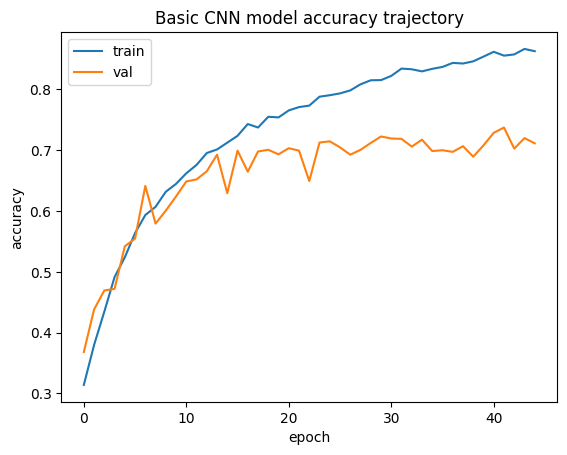

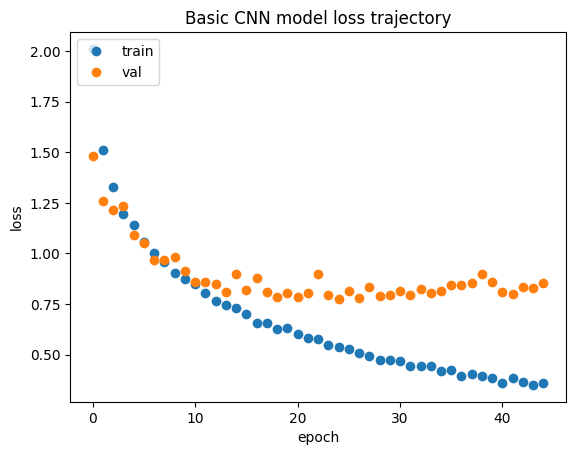

In [8]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [9]:
## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.6884875893592834


## Reduce learning rate for fine-tuning of model

In [10]:
# Model parameters
learning_rate = 1e-6
epochs = 15
cnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

In [11]:
# Compiling the model
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,   
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)



Epoch 1/15


109/109 [==============================] - 7s 55ms/step - loss: 0.5452 - accuracy: 0.7833 - val_loss: 0.7616 - val_accuracy: 0.7207
Epoch 2/15
109/109 [==============================] - 5s 50ms/step - loss: 0.5410 - accuracy: 0.7911 - val_loss: 0.7577 - val_accuracy: 0.7233
Epoch 3/15
109/109 [==============================] - 5s 48ms/step - loss: 0.5243 - accuracy: 0.7980 - val_loss: 0.7552 - val_accuracy: 0.7287
Epoch 4/15
109/109 [==============================] - 10s 91ms/step - loss: 0.5290 - accuracy: 0.7928 - val_loss: 0.7533 - val_accuracy: 0.7273
Epoch 5/15
109/109 [==============================] - 11s 98ms/step - loss: 0.5199 - accuracy: 0.7974 - val_loss: 0.7531 - val_accuracy: 0.7287
Epoch 6/15
109/109 [==============================] - 11s 98ms/step - loss: 0.5133 - accuracy: 0.8055 - val_loss: 0.7523 - val_accuracy: 0.7300
Epoch 7/15
109/109 [==============================] - 11s 98ms/step - loss: 0.5059 - accuracy: 0.8082 - val_loss: 0.7522 - val_accuracy: 0.7280
Epoch 

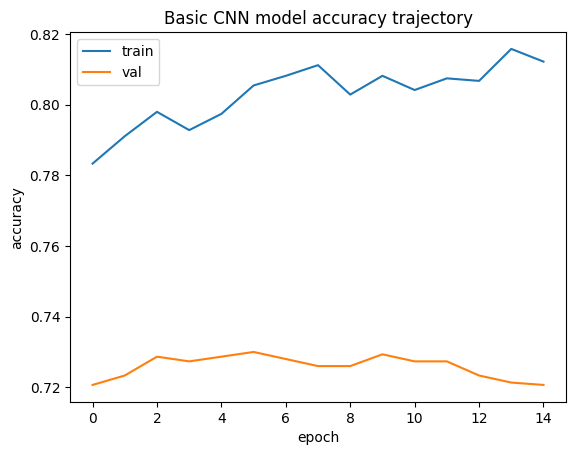

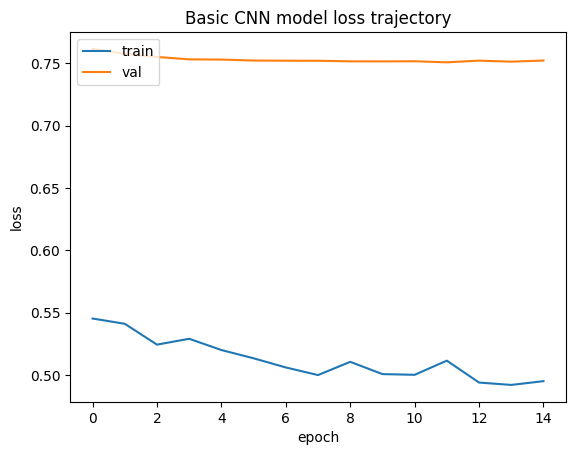

Test accuracy of the basic CNN model: 0.7133182883262634


In [12]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'])
plt.plot(basic_cnn_model_results.history['val_loss'])
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

## Test on Subject 0

In [13]:
def test_single(model, sub_idx=None, time_period=1000):
    X_test_cur = x_test[:, :, :time_period]
    y_test_cur = y_test
    
    if sub_idx is not None:
        X_test_cur = X_test_cur[np.where(person_test == sub_idx)[0]]
        y_test_cur = y_test[np.where(person_test == sub_idx)[0]]

    test_score = model.evaluate(X_test_cur, y_test_cur)

    return test_score


In [14]:
test_single_score = test_single(basic_cnn_model, sub_idx = 0)
print('Test accuracy of the basic CNN model on Subject 0:',test_single_score[1])

2/2 [==============================] - 0s 25ms/step - loss: 0.9672 - accuracy: 0.7000


Test accuracy of the basic CNN model on Subject 0: 0.699999988079071


## Declare CNN instance for training of different time bins

In [15]:
def cnn(time_period=1000):
    # Building the CNN model using sequential class
    basic_cnn_model = Sequential()

    # Conv. block 1
    basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(22,time_period,1)))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 2
    basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 3
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 4
    basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Output layer with Softmax activation
    basic_cnn_model.add(Flatten()) # Flattens the input
    basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

    cnn_optimizer = keras.optimizers.Adam(lr=learning_rate)
    basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,   
                 metrics=['accuracy'])
    
    # Printing the model summary
    basic_cnn_model.summary()
    
    return basic_cnn_model


In [16]:
def data_prep(X,y,sub_sample,average,noise,time):
    
    total_X = None
    total_y = None
    
    # Noise 
    X_average = X + np.random.normal(0.0, 0.5, X.shape)
    
    total_X =  X_average
    total_y =  y

    print('Shape of X after noise:',total_X.shape)

    return total_X,total_y

In [17]:
def load_data_time_bin(time, debug=True, onehot=False, time_bin=True): 

## Loading the dataset
    X_test = np.load("X_test.npy")
    y_test = np.load("y_test.npy")
    person_train_valid = np.load("person_train_valid.npy")
    X_train_valid = np.load("X_train_valid.npy")
    y_train_valid = np.load("y_train_valid.npy")
    person_test = np.load("person_test.npy")

    ## Adjusting the labels so that 

    # Cue onset left - 0
    # Cue onset right - 1
    # Cue onset foot - 2
    # Cue onset tongue - 3

    y_train_valid -= 769
    y_test -= 769

    print(X_train_valid.shape)
    print(y_train_valid.shape)
    print(X_test.shape)
    print(y_test.shape)
    print (person_train_valid.shape)
    print (person_test.shape)

    ## Preprocessing dataset
    if time_bin:
      X_train_valid,y_train_valid = data_prep(X_train_valid,y_train_valid,2,2,True,time)

    if debug:
        print('Shape of training/validation set:',X_train_valid.shape)
        print('Shape of training/validation labels:',y_train_valid.shape)
        print('Shape of testing set:',X_test.shape)
        print('Shape of testing labels:',y_test.shape)


    if onehot:
        # Converting the labels to categorical variables for multiclass classification
        y_train_valid = to_categorical(y_train_valid, 4)
        y_test = to_categorical(y_test, 4)
        if debug:
            print('Shape of training/valid labels after categorical conversion:',y_train_valid.shape)
            print('Shape of test labels after categorical conversion:',y_test.shape)

    # Adding width of the segment to be 1
    X_train_valid = X_train_valid.reshape(X_train_valid.shape[0], X_train_valid.shape[1], X_train_valid.shape[2], 1)
    x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    if debug:
        print('Shape of training set after adding width info:',X_train_valid.shape)
        print('Shape of test set after adding width info:',x_test.shape)


    # Reshaping the training and validation dataset
    # x_train = np.swapaxes(x_train, 1,3)
    # x_train = np.swapaxes(x_train, 1,2)
    # x_valid = np.swapaxes(x_valid, 1,3)
    # x_valid = np.swapaxes(x_valid, 1,2)
    # x_test = np.swapaxes(x_test, 1,3)
    # x_test = np.swapaxes(x_test, 1,2)
    if debug:
        print('Shape of training set after dimension reshaping:',x_train.shape)
        print('Shape of validation set after dimension reshaping:',x_valid.shape)
        print('Shape of test set after dimension reshaping:',x_test.shape)

    return X_train_valid, y_train_valid, x_test, y_test

In [18]:
time = 1000
## Preprocessing the dataset

x_train_valid, y_train_valid, x_test, y_test = load_data_time_bin(time=time, onehot=True, time_bin=True)

(2115, 22, 1000)
(2115,)
(443, 22, 1000)
(443,)
(2115, 1)
(443, 1)
Shape of X after noise: (2115, 22, 1000)
Shape of training/validation set: (2115, 22, 1000)
Shape of training/validation labels: (2115,)
Shape of testing set: (443, 22, 1000)
Shape of testing labels: (443,)
Shape of training/valid labels after categorical conversion: (6960, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (2115, 22, 1000, 1)
Shape of test set after adding width info: (443, 22, 1000, 1)
Shape of training set after dimension reshaping: (6960, 250, 1, 22)
Shape of validation set after dimension reshaping: (1500, 250, 1, 22)
Shape of test set after dimension reshaping: (443, 22, 1000, 1)


## Training of Model for different time bins

In [19]:
def train(time_period=1000):
    # Time Bins
    X_train_valid_cur = x_train_valid[:, :, :time_period]
    y_train_valid_cur = y_train_valid
    X_test_cur = x_test[:, :, :time_period]
    y_test_cur = y_test

    model = cnn(time_period)

    # Define early stopping criteria
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    results = model.fit(X_train_valid_cur, y_train_valid_cur, epochs=40, batch_size=32, validation_data=(X_test_cur, y_test_cur), callbacks=[early_stopping], shuffle=True, verbose=1)
    train_score = model.evaluate(X_train_valid_cur, y_train_valid_cur)
    test_score = model.evaluate(X_test_cur, y_test_cur)

    print('Train {:s}: {:.3f}%'.format(model.metrics_names[1], train_score[1]*100))
    print('Test {:s}: {:.3f}%'.format(model.metrics_names[1], test_score[1]*100))
    print(model.summary())
    
    return results, train_score, test_score

250


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 22, 250, 25)       275       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 250, 25)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 8, 250, 25)       100       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 8, 250, 25)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 250, 50)        12550     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 250, 50)      

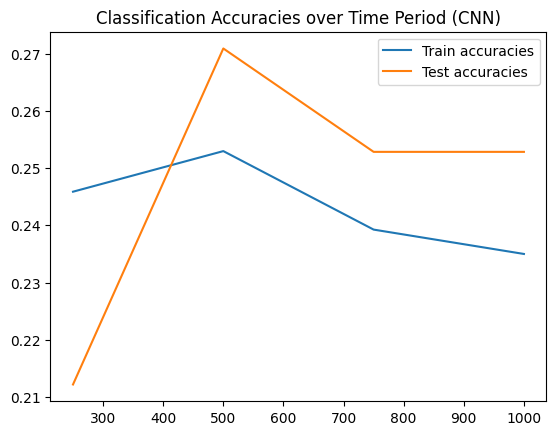

In [20]:
train_scores = []
test_scores = []

for time in range(250, 1001, 250):
    print(str(time))
    results, train_score, test_score = train(time_period=time)
    train_scores.append(train_score[1])
    test_scores.append(test_score[1])

print("Train accuracies: ")
print(train_scores)
print("Test accuracies: ")
print(test_scores)
max_idx = np.argmax(test_scores)
print("The best accuracy is %.3f." %max(test_scores))
print("The corresponding time period is %d." %(250 + 250 * max_idx))

# plot
plt.plot(range(250, 1001, 250), train_scores, label='Train accuracies')
plt.plot(range(250, 1001, 250), test_scores, label='Test accuracies')
plt.legend()
plt.title("Classification Accuracies over Time Period (CNN)")
plt.show()